# Using the LSST DM Stack in Python

This tutorial focuses on using the DM stack in Python.  Some of the things we'll be doing are more commonly done on the command-line, via executable scripts the stack also provides.  More complete tutorials for data processing and command-line functionality can be found in the [Science Pipelines documentation](https://pipelines.lsst.io/getting-started/index.html) and [DM Tech Note 23](https://dmtn-023.lsst.io/).

More notebook examples can be found here: https://github.com/RobertLuptonTheGood/notebooks/tree/master/Demos

## Data Repository Setup

Instead of operating directly on files and directories, we interact with on-disk data products via an abstraction layer called the *data butler*.  The butler operates on *data repositories*.  For this tutorial we have setup a data repository on lsp-demo, at `/project/ci_hsc_small` read-only space. This data repository contains some raw data, master calibration files, transmission curves data, and an external reference catalog.  All of these are from a self-contained test dataset we call [ci_hsc](https://github.com/lsst/ci_hsc).  The full ci_hsc dataset includes just enough data to run the full (current) LSST pipeline, which extends through processing coadds from multiple bands together.  In this tutorial we'll focus on processing an individual image, and that's all this particular subset will support.  We also won't go into the details of how to build master calibration files or reference catalogs here.

First, copy the data repository to your home space, where you have full permission to create and manage data.  Open a terminal window and do:

    cp -r /project/ci_hsc_small/* $HOME/WORK

In this tutorial `$HOME/WORK` is your working data repository.

In [1]:
import os
WORK_DIR = os.path.join(os.environ['HOME'], "WORK")
print(WORK_DIR)

/home/ctslater/WORK


## Instrument Signature Removal and Command-Line Tasks

Before we can start doing *interesting* things, we need some minimally processed images (i.e. flat-fielded, bias-corrected, etc).  Because the HSC team has spent a lot of time characterizing the instrument, we really want to run this step with the default configuration they've provided.  That's also much actually easier to do from the command-line, and while we *could* do it from Python, that'd involve a lot of little irrelevant workarounds we'd rather not get bogged down in.

ISR is implemented as a subclass of `lsst.pipe.base.Task`.  Nearly all of our high-level algorithms are implemented as `Task`s, which are essentially just callable objects that can be composed (a high-level `Task` can hold one or more lower-level "subtasks", to which it can delegate work) and configured (every task takes an instance of a configuration class that controls what it does in detail).  ISR is actually a `CmdLineTask`, a special kind of task that can be run from the command-line and use the data butler for all of its inputs and outputs (regular `Task`s generally do not use the butler directly).  Unlike virtually every other algorithm, there is a different ISR `Task` for each major camera (though there's also a simple default one), reflecting the specialized processing that's needed at this level.

But (for uninteresting, historical reasons), it's not currently possible to run `IsrTask` from the command-line.  Instead, what we can do is run a parent `CmdLineTask`, `lsst.pipe.tasks.ProcessCcdTask`, which will run `IsrTask` as well as a few other steps.  By default, it doesn't actually save the image directly after ISR is run - it performs a few more operations first, and then saves that image.  But we can tell it to do so by modifying the tasks' configuration when we.

In a terminal session, load the LSST environment and setup the software stack by doing:

    source /opt/lsst/software/stack/loadLSST.bash
    setup lsst_distrib

The full command-line for running `ProcessCcdTask` is below:

    processCcd.py $HOME/WORK --rerun isr --id visit=903334 ccd=16 --config isr.doWrite=True

Alternatively, we can use a Jupyter trick (the `%%script bash` line) to do that within the notebook: 

In [ ]:
%%script bash
processCcd.py $HOME/WORK --rerun isr --id visit=903334 ccd=16 --config isr.doWrite=True

There are a few features of this command-line that bear explaining:
 - We run `processCcd.py`, not `ProcessCcdTask`.  There's a similar driver script for all `CmdLineTask`s, with the name formed by making the first word lowercase and removing the `Task` suffix.  These are added to your `PATH` when you set up the LSST package in which they're defined (which happens automatically in the JupyterLab environment).
 - The first argument to any command-line task is the path an input data repository.
 - We've used the `--rerun` argument to set the location of the output repository, in this case `$HOME/WORK/rerun/isr`.  You can also use `--output` to set the path more directly, but we recommend `--rerun` because it enforces a nice convention for where to put outputs that helps with discoverability.
 - The `--id` argument sets the *data ID(s)* to be processed, in this case a single CCD from a single visit.  All `CmdLineTasks` share a fairly sophisticated syntax for expressions that match multiple data IDs, which you can learn more about by running any `CmdLineTask` with `--help`.
 - We've overridden a configuration value with the `--config` option, in this case to make sure the just-after-ISR image file is written.  Running a `CmdLineTask` automatically also includes applying configuation overrides that customize the task for the kind of data you're processing (i.e. which camera it comes from), and that's how the task knows to run the custom ISR task for HSC, rather than the generic default.  You can see all of the config options for a `CmdLineTask` by running with `--show config`, though the results can be a bit overwhelming.
 
The rest of this tutorial is focused on using LSST software as a Python library, so this will be the last thing we run from the command-line.  Again, for more information about how to run LSST's existing processing scripts from the command-line, check out [DM Tech Note 23](https://dmtn-023.lsst.io/).

## Data Access with Butler

The outputs of `CmdLineTasks`, like their inputs, are organized into data repositories, which are managed by an object called `Butler`.  To retrieve a dataset from the `Butler`, we start by constructing one pointing to the output repository from the processing run (which is now an input repository for this `Butler`, which won't have an output repository since we won't be writing any more files):

In [1]:
from lsst.daf.persistence import Butler

datadir = '/home/YOUR_USER_NAME/ci_hsc_small/rerun/YOUR_RERUN_NAME'
butler = Butler(datadir)

We can then call `get` with the name and data ID of the dataset.  The name of the image that's saved directly after ISR is `postISRCCD`.

In [2]:
exposure = butler.get("postISRCCD", visit=903334, ccd=16)

## Image, Boxes, and (Crude) Image Display

A full 2k x 4k HSC CCD is a pretty big image to display when you don't have specialized display code.  The DM stack does have specialized display code, but it either requires DS9 (which requires some ssh tunnels to use with data living on a server) or a Firefly server installation. For this tutorial, we'll just throw together a naive matplotlib display function, and create a view to a subimage that we'll display instead of the full image.

This section features a few of our most important class objects:

- `lsst.afw.image.Exposure` is an image object that actually holds three image planes: the science image (`Exposure.image`), an image of variance in every pixel (`Exposure.variance`), an integer bit mask (`Exposure.mask`).  It also holds a lot of more complex objects that characterize the image, such as a point-spread function (`lsst.afw.detection.Psf`) and world-coordinate system (`lsst.afw.image.Wcs`).  Most of these objects aren't filled in yet, because all we've run so far is ISR.  It doesn't generally make sense to perform mathematical operations (i.e. addition) on `Exposure`s, because those operations aren't always well-defined on the more complex objects.  You can get a `MaskedImage` object with the same image, mask, and variance planes that does support mathematical operations but doesn't contain `Psf`s and `Wcs`s (etc) with `Exposure.maskedImage`.

- The `Exposure.image` and `Exposure.variance` properties return `lsst.afw.image.Image` objects.  These have a `.array` property that returns a `numpy.ndarray` view to the `Image`'s pixels.  Conceptually, you should think of an `Image` as just a `numpy.ndarray` with a possibly nonzero origin.

- The `Exposure.mask` property returns a `lsst.afw.image.Mask` object, which behaves like an `Image` with a dictionary-like object that relates string labels to bit numbers.

- All of these image-like objects have a `getBBox()` method, which returns a `lsst.afw.geom.Box2I`.  The minimum and maximum points of a `Box2I` are specified in integers that correspond to the *centers* of the lower-left and upper-right pixels in the box, but the box conceptually contains the entirety of those pixels.  To get a box with a floating-point representation of the same boundary for the `extent` argument to `imshow` below, we construct a `Box2D` from the `Box2I`.

- `Point2I` and `Extent2I` are used to represent absolute positions and offsets between positions as integers (respectively).  These have floating-point counterparts `Point2D` and `Extent2D`.

In [6]:
from lsst.afw.geom import Box2D, Box2I, Point2I, Extent2I
from lsst.afw.image import Exposure

In [79]:
# Execute this cell (and the one below) to re-load the post-ISR Exposure from disk after
# modifying it.
exposure = butler.get("postISRCCD", visit=903334, ccd=16)

In [4]:
bbox = exposure.getBBox()
print(bbox)

(minimum=(0, 0), maximum=(2047, 4175))


In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lsst.afw.display as afw_display
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["figure.dpi"] = 120

And now here's the (cutout) of the detrended image.  I've cheated in setting the scale by looking at the background level in advance.

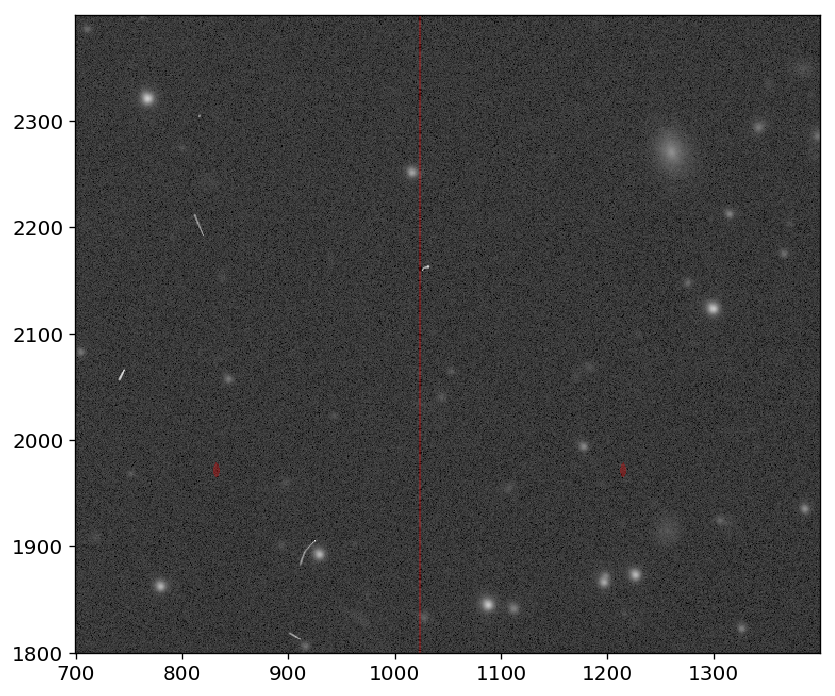

In [12]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.mtv(exposure[700:1400,1800:2400])

## Background Subtraction and Task Configuration

The next step we usually take is to estimate and subtract the background, using `lsst.meas.algorithms.SubtractBackgroundTask`.  This is a regular `Task`, not a `CmdLineTask`, and hence we'll just pass it our `Exposure` object (it operates in-place) instead of a `Butler`.

In [13]:
from lsst.meas.algorithms import SubtractBackgroundTask

In [14]:
bkgConfig = SubtractBackgroundTask.ConfigClass()

In [15]:
# Execute this cell to get fun & terrible results!
bkgConfig.useApprox = False
bkgConfig.binSize = 20

The pattern for configuration here is the same as it was for `SubaruIsrTask`, but here we're setting values directly instead of loading a configuration file from the `obs_subaru` camera-specialization package.  The `config` object here is an instance of a class that inherits from `lsst.pex.config.Config` that contains a set of `lsst.pex.config.Field` objects that define the options that can be modified.  Each `Field` behaves more or less like a Python `property`, and you can get information on all of the fields in a config object by either using `help`:

In [ ]:
help(bkgConfig)

In [ ]:
SubtractBackgroundTask.ConfigClass.algorithm?

In [17]:
bkgTask = SubtractBackgroundTask(config=bkgConfig)

In [18]:
bkgResult = bkgTask.run(exposure)

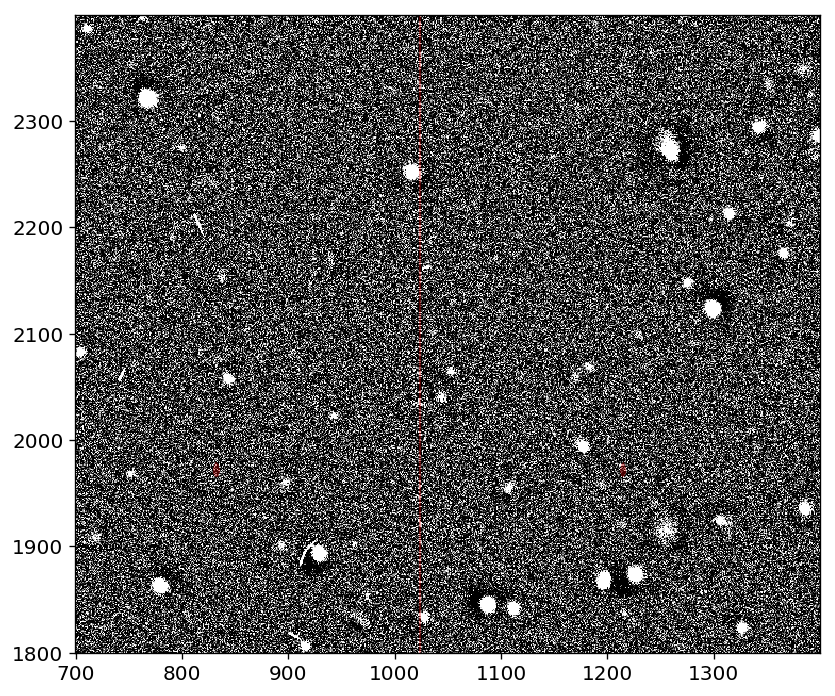

In [20]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", min=-0.5, max=10)
display1.mtv(exposure[700:1400,1800:2400])

If you've run through all of these steps after executing the cell that warns about terrible results, you should notice that the galaxy in the upper right has been oversubtracted.

**Exercise**: Before continuing on, re-load the exposure from disk, reset the configuration and `Task` instances, and re-run without executing the cell that applies bad values to the config, all by just re-executing the right cells above.  You should end up an image in which the upper-right galaxy looks essentially the same as it does in the image before we subtracted the background.

## Installing an Initial-Guess PSF

Most later processing steps require a PSF model, which is represented by a `Psf` object that's attached to the `Exposure`.  For now, we'll just make a Gaussian PSF with some guess at the seeing.

In [21]:
from lsst.meas.algorithms import SingleGaussianPsf

In [22]:
FWHM_TO_SIGMA = 1.0/(2*np.sqrt(2*np.log(2)))
PIXEL_SCALE = 0.168  # arcsec/pixel
SEEING = 0.7         # FWHM in arcsec
sigma = FWHM_TO_SIGMA*SEEING/PIXEL_SCALE
width = int(sigma*3)*2 + 1
psf = SingleGaussianPsf(width, width, sigma=sigma)
exposure.setPsf(psf)

A `Psf` object can basically just do one thing: it can return an image of itself at a point.  `SingleGaussianPsf` represents a constant PSF, so it always returns the same image, regardless of the point you give it.

But there are two ways to evaluate a `Psf` at a point.  If you want an image centered on the middle pixel, and that middle pixel to be the origin - what you'd usually want if you're going to convolve the PSF with another model - use `computeKernelImage(x, y)`:

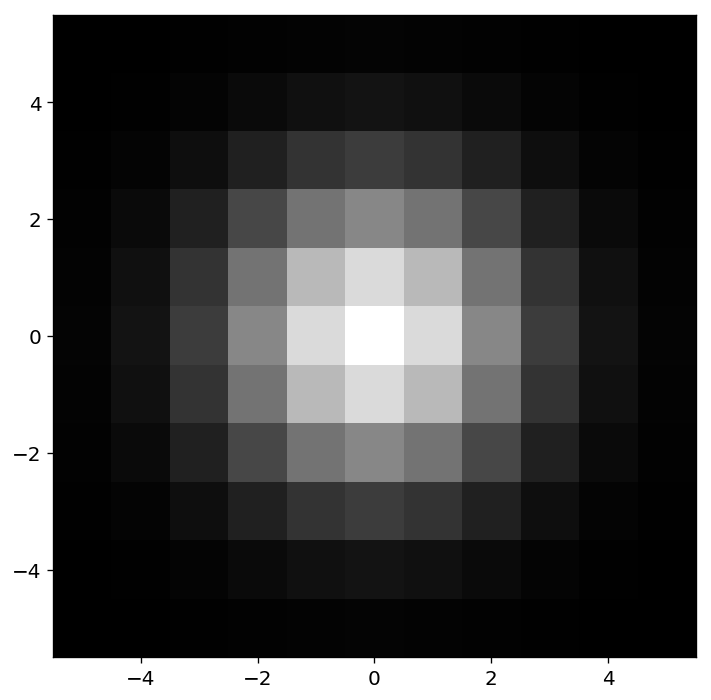

In [26]:
from lsst.afw.geom import Point2D
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.mtv(psf.computeKernelImage(Point2D(60.5, 7.2)))


If you want to compare the PSF to a star at the exact same position, use `computeImage(x, y)`.  That will shift the image returned by `computeKernelImage(x, y)` to the right sub-pixel offset, and update the origin of the image to take care of the rest, so you end up with a postage stamp in the same coordinate system as the original image where the star is.

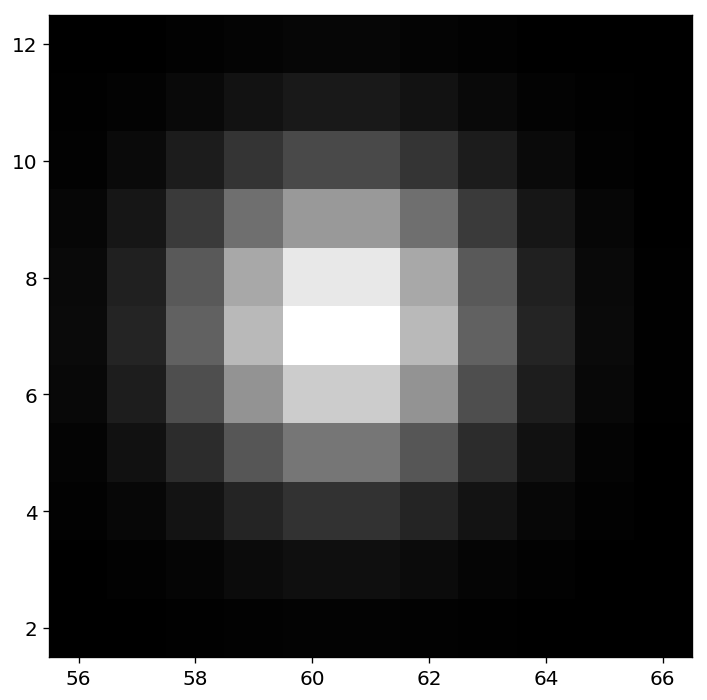

In [27]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.mtv(psf.computeImage(Point2D(60.5, 7.2)))

## Removing Cosmic Rays

Cosmic rays are detected and interpolated by `RepairTask`, which also sets mask planes to indicate where the cosmic rays were ("CR") and which pixels were interpolated ("INTERP"; this may happen due to saturation or bad pixels as well).  Because we're just using the default configuration, we can skip creating a config object and just construct the `Task` with no arguments.

In [28]:
from lsst.pipe.tasks.repair import RepairTask

In [29]:
repairTask = RepairTask()

In [30]:
repairTask.run(exposure)

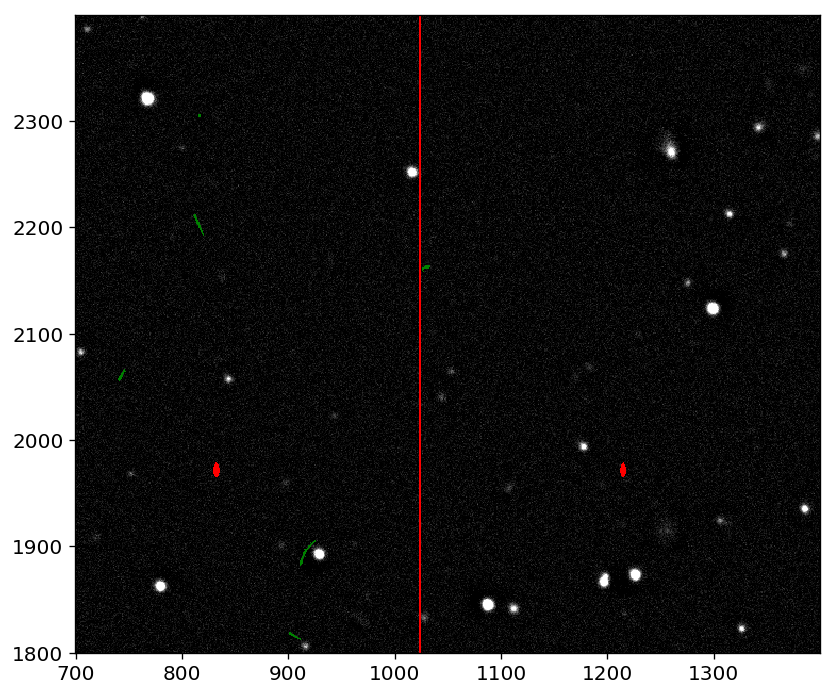

In [33]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", min=-0.5, max=100)
display1.setMaskTransparency(0)
display1.mtv(exposure[700:1400,1800:2400])

## Detecting Sources

Unlike the other `Task`s we've dealt with so far, `SourceDetectionTask` creates a `SourceCatalog` in addition to updating the image (all it does to the image is add a "DETECTED" mask plane).  All `Task`s that work with catalogs need to be initialized with a `lsst.afw.table.Schema` object, to which the `Task` will add the fields necessary to store its outputs.  A `SourceCatalog`'s `Schema` cannot be modified after the `SourceCatalog` has been constructed, which means it's necessary to construct all `Schema`-using `Task`s before actually running any of them.

Each record in the catalog returned by `SourceDetectionTask` has a `Footprint` object attached to it.  A `Footprint` represents the approximate region covered by a source in a run-length encoding data structure.  It also contains a list of peaks found within that region.  The "DETECTED" mask plane is set to exactly the pixels covered by any `Footprint` in the returned catalog.

In [34]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.afw.table import SourceTable, SourceCatalog

In [35]:
schema = SourceTable.makeMinimalSchema()

In [36]:
detectTask = SourceDetectionTask(schema=schema)

In [37]:
# A SourceTable is really just a factory object for records; don't confuse it with SourceCatalog, which is
# usually what you want.  But a SourceTable *is* what SourceDetectionTask wants here.
table = SourceTable.make(schema)

In [38]:
detectResult = detectTask.run(table, exposure)

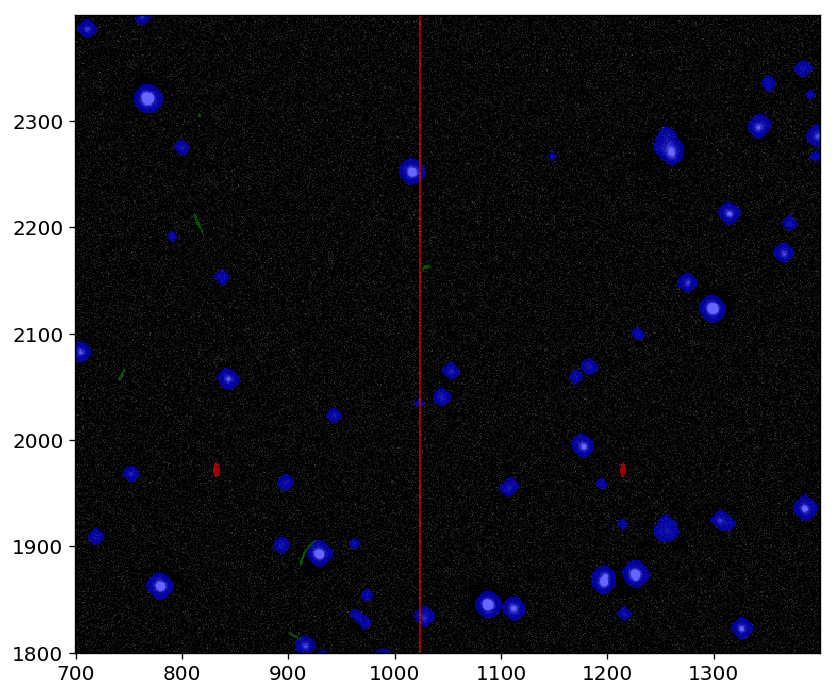

In [40]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", min=-0.5, max=100)
display1.setMaskTransparency(40)
display1.mtv(exposure[700:1400,1800:2400])

# Exercises

0. Make a scatter plot of Kron Flux vs. Psf Flux.

1. Write a single function that performs all of the above steps on a post-ISR `Exposure` object, modifying the `Exposure` in-place and returning a new `SourceCatalog` with a complete set of measurements.

2. Add PSF modeling to the end of that function, delegating most of the work to `lsst.pipe.tasks.MeasurePsfTask`.  You may want to use a higher threshold (e.g. 50-sigma) for detection, since PSF modeling should only use bright stars.

3. Make images of the PSF stars, the PSF model at the position of those stars, and the difference between them.

4. Add another detect-deblend-measure sequence after PSF modeling at a deeper threshold.

5. Rewrite the function as a class that constructs all of the `Task`s that it use in `__init__` and processes a single `Exposure` with you call its `run` method.  Make sure it will behave properly if `run` is called multiple times wiht different `Exposure` objects.


- 